In [ ]:
#  !wget https://www.dropbox.com/s/xq4vosn9xyn1dy1/grouped_data.pickle?dl=0 -O grouped_data.pickle
!wget https://www.dropbox.com/s/d56twlngo1gky49/30000-40000.p?dl=0 -O textlabeldata.pickle

--2021-05-02 01:48:36--  https://www.dropbox.com/s/d56twlngo1gky49/30000-40000.p?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/d56twlngo1gky49/30000-40000.p [following]
--2021-05-02 01:48:36--  https://www.dropbox.com/s/raw/d56twlngo1gky49/30000-40000.p
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9a0f2391b645f548bf271c1e08.dl.dropboxusercontent.com/cd/0/inline/BNsdJK2IqzO12m0unLUiSApqAGw8sVYXpDq9PJhMvlGb0LM33XPIsOcQ485U5HT3RzdaEmfQUwRasapGL34HIq1sLEopwVoZeny-9dpC-VPeyCQCv_r999SFqpdZZSL3ZEA_BAz4QXpYngQdcvXFGEyz/file# [following]
--2021-05-02 01:48:36--  https://uc9a0f2391b645f548bf271c1e08.dl.dropboxusercontent.com/cd/0/inline/BNsdJK2IqzO12m0unLUiSApqAGw8sVYXpDq9PJhMvlGb0LM33XPIsOcQ485U5HT3RzdaEmfQUwRasapGL3

In [ ]:
import torch
import torch.nn as nn
!pip install transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
import copy
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [ ]:
class BERT():
    def __init__(self, path='bert-base-uncased', cuda=False):
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model = BertModel.from_pretrained(path)

        self.cuda = cuda

        self.load_model()
        pass

    def convert(self, words_list, method='average'):
        tokens = self.tokenizer.encode(' '.join(words_list))
        input_ids = torch.tensor(tokens).unsqueeze(0)

        if self.cuda:
            input_ids.cuda()
        outputs = self.model(input_ids)
        last_hidden_states = outputs[0]
        return last_hidden_states.squeeze(0).mean(axis=0).cpu().detach().numpy()
    
    def load_model(self):
        pass

In [ ]:
# with open('grouped_data.pickle', 'rb') as f:
#     data = pickle.load(f)

In [ ]:
bert = BERT(path='bert-base-uncased', cuda=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', use_cache=True)

In [ ]:
# texts = []
# labels = []
# for key in tqdm(list(data.keys())):
#     post = data[key][0]
#     comments = data[key][1]
#     title = post['title']
#     try:
#         text = post['selftext']
#     except:
#         text = ""
    
#     full_post = title + " " + text
#     for comment in comments:
#         if comment["body"] != "[deleted]":
#             post_encodings = bert.convert(tokenizer(full_post))
#             comment_encodings = bert.convert(tokenizer(comment["body"]))
#             texts.append(np.array([post_encodings, comment_encodings]))
#             labels.append(comment["score"])


texts, labels = pickle.load(open('textlabeldata.pickle', 'rb'))

In [ ]:
class UpvoteRegression(nn.Module):
    def __init__(self):
        super(UpvoteRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=768 * 2, out_features=1000, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1000, out_features=500, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=500, out_features=200, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=200, out_features=1, bias=True))

    def forward(self, x):
        # for layer in self.model:
        #   x = layer(x)
        #   print(layer, x.shape)
        # outs = x

        outs = self.model(x)
        return outs

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.shape[0]
    _, pred = torch.max(output, dim=-1)
    correct = pred.eq(target).sum() * 1.0
    acc = correct / batch_size
    return acc

def train(model, dataloader, optimizer, criterion, scheduler = None):
    losses = AverageMeter()
    acc = AverageMeter()

    model.train()

    # Get the progress bar for later modification
    # progress_bar = tqdm(dataloader)

    # Mini-batch training
    # for batch_idx, (data, target) in enumerate(progress_bar):
    for batch_idx, (data, target) in enumerate(dataloader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        batch_acc = accuracy(out, target)

        losses.update(loss, out.shape[0])
        acc.update(batch_acc, out.shape[0])
        
    
    return acc.avg, losses.avg

def evaluate(model, dataloader, criterion):

    losses = AverageMeter()
    acc = AverageMeter()
    
    # Set the model to eval mode to avoid weights update
    model.eval()

    with torch.no_grad():
        # Get the progress bar 
        # progress_bar = tqdm(dataloader)
        # for batch_idx, (data, target) in enumerate(progress_bar):
        for batch_idx, (data, target) in enumerate(dataloader):
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
        
            
#         progress_bar = tqdm(dataloader)
#         for (data, target) in enumerate(dataloader):          

            out = model(data)

            batch_acc = accuracy(out, target)
            loss = criterion(out, target)
            
            losses.update(loss, out.shape[0])
            acc.update(batch_acc, out.shape[0])
            
#             progress_bar.set_description_str("Batch: %d, Loss: %.4f" % ((batch_idx+1), loss.val))
    
    return acc.avg, losses.avg

In [ ]:
model = UpvoteRegression().to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1)

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.05, shuffle=True)

print(len(train_texts), len(test_texts))

140780 7410


In [ ]:
class upvote_prediction_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = torch.tensor(self.encodings[idx]).flatten()
        label = torch.tensor(self.labels[idx]).float().flatten()
        return (item, label)

    def __len__(self):
        return len(self.labels)

train_set = upvote_prediction_dataset(train_texts, train_labels)
valid_set = upvote_prediction_dataset(test_texts, test_labels)


train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

In [ ]:
losses = []
accs = []

epochs = 100

best_cm = None
best_model = None
best = -np.inf

model.train()
progress_bar = tqdm(range(epochs))
for epoch in progress_bar:

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    val_acc, val_loss = evaluate(model, valid_loader, criterion)

    accs.append(val_acc)
    losses.append(val_loss)

    progress_bar.set_description_str("Epoch: %d, Loss: %.4f" % ((epoch+1), val_loss))

    # if acc > best:
        # best = acc
        # best_cm = cm
        # best_model = copy.deepcopy(model)
        # torch.save(best_model.statedict(), './checkpoints/' + args.model.lower() + '' + args.cfg + '.pth')

In [ ]:
model.eval()

max = -np.inf
max_idx = None 

for idx, item in enumerate(train_set):
  if (max < item[1][0]):
    max = item[1][0]
    max_idx = idx

print(train_set[max_idx][1])
model(train_set[max_idx][0].to(device))

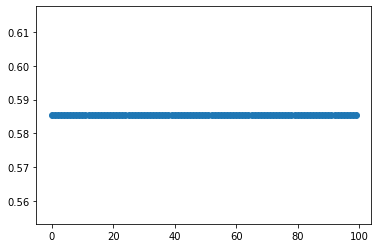

In [ ]:
losses = [loss.cpu().detach().numpy() for loss in losses]
losses = np.array(losses).flatten()
plt.scatter(range(len(losses)), losses)

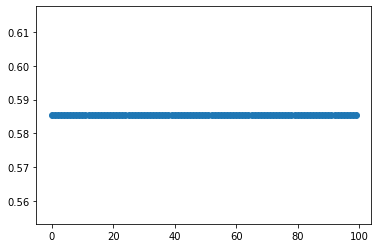

In [ ]:
accs = [acc.cpu().detach().numpy() for acc in accs]
accs = np.array(accs).flatten()
plt.scatter(range(len(accs)), accs)